In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [34]:
# --- 1. Configuration and Data Loading ---

# Define main data directories
DATA_DIR = 'ASL'
TRAIN_DIR = os.path.join(DATA_DIR, 'asl_train')

In [35]:
# Model and training parameters
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
EPOCHS = 10
VALIDATION_SPLIT = 0.2 # Use 20% of training data for validation

# Load the training dataset from the directory
# This utility automatically infers the class labels from the subdirectory names.
train_dataset = image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='int', # Use integers for labels (for sparse_categorical_crossentropy)
    image_size=IMG_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=VALIDATION_SPLIT,
    subset='training'
)

# Load the validation dataset from the same directory
validation_dataset = image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=VALIDATION_SPLIT,
    subset='validation'
)

Found 223074 files belonging to 29 classes.
Using 178460 files for training.
Found 223074 files belonging to 29 classes.
Using 44614 files for validation.


In [36]:
# Get class names from the dataset
# These will be ['A', 'B', 'C', ..., 'Z', 'del', 'nothing', 'space']
class_names = train_dataset.class_names
num_classes = len(class_names)
print(f"Found {num_classes} classes: {class_names}")

# Save class names to a file for the Streamlit app to use
with open('class_names.txt', 'w') as f:
    for item in class_names:
        f.write("%s\n" % item)
print("Saved class names to 'class_names.txt'")

Found 29 classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Saved class names to 'class_names.txt'


In [21]:
# Optimize data loading performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
# --- 2. Build the CNN Model ---

model = Sequential([
    # Input layer: Rescale pixel values from [0, 255] to [0, 1]
    Rescaling(1./255, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),

    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Flatten the feature maps to a 1D vector
    Flatten(),

    # Dense layers for classification
    Dense(256, activation='relu'),
    Dropout(0.5), # Dropout for regularization to prevent overfitting
    Dense(num_classes, activation='softmax') # Output layer with softmax for multi-class classification
])

D:\CLG\python\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print a summary of the model architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 29)                  │           7,453 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,198,109 (8.39 MB)

 Trainable params: 2,198,109 (8.39 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# --- 3. Train the Model ---

print("\n--- Starting Model Training ---")
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS
) 
print("--- Model Training Finished ---\n")


--- Starting Model Training ---
Epoch 1/10
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 761s 136ms/step - accuracy: 0.7534 - loss: 0.7967 - val_accuracy: 0.9611 - val_loss: 0.1376
Epoch 2/10
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 596s 107ms/step - accuracy: 0.9294 - loss: 0.2205 - val_accuracy: 0.9790 - val_loss: 0.0682
Epoch 3/10
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 602s 108ms/step - accuracy: 0.9532 - loss: 0.1481 - val_accuracy: 0.9884 - val_loss: 0.0412
Epoch 4/10
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 622s 112ms/step - accuracy: 0.9641 - loss: 0.1129 - val_accuracy: 0.9877 - val_loss: 0.0420
Epoch 5/10
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 639s 114ms/step - accuracy: 0.9688 - loss: 0.0981 - val_accuracy: 0.9906 - val_loss: 0.0332
Epoch 6/10
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 566s 101ms/step - accuracy: 0.9739 - loss: 0.0841 - val_accuracy: 0.9922 - val_loss: 0.0272
Epoch 7/10
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 320s 57ms/step - accuracy: 0.9772 - loss: 0.0748 - val_accuracy: 0.9942 - val_loss: 0.0230
Epoch 8/10
5577/5577 ━━━━━━━━━

In [31]:
# --- 4. Save the Trained Model ---
model.save('asl_model.h5')
print("Model saved successfully as 'asl_model.h5'")

Model saved successfully as 'asl_model.h5'


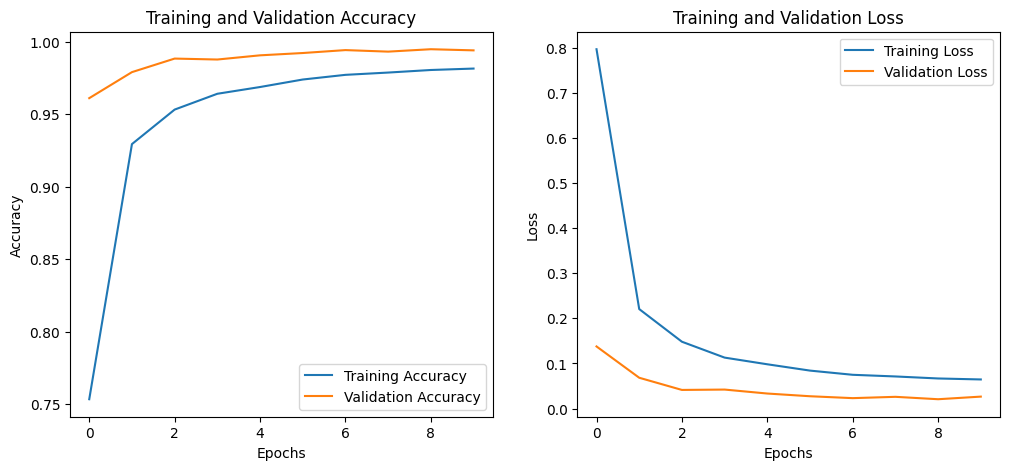

In [25]:
# --- 5. Visualize Training Results ---

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Save the plot
#plt.savefig('training_history.png')
#print("Saved training history plot to 'training_history.png'")
plt.show()



--- Evaluating on Validation Set ---

--- Classification Report ---
              precision    recall  f1-score   support

           A       0.99      0.99      0.99      1734
           B       0.99      1.00      1.00      1726
           C       1.00      1.00      1.00      1659
           D       0.99      1.00      0.99      1485
           E       0.99      0.99      0.99      1516
           F       0.99      1.00      0.99      1587
           G       1.00      0.99      0.99      1566
           H       1.00      1.00      1.00      1552
           I       1.00      0.99      0.99      1570
           J       1.00      1.00      1.00      1498
           K       0.99      0.99      0.99      1614
           L       0.99      1.00      1.00      1621
           M       0.98      0.99      0.99      1595
           N       0.99      0.98      0.99      1617
           O       1.00      0.99      0.99      1645
           P       1.00      1.00      1.00      1515
           Q

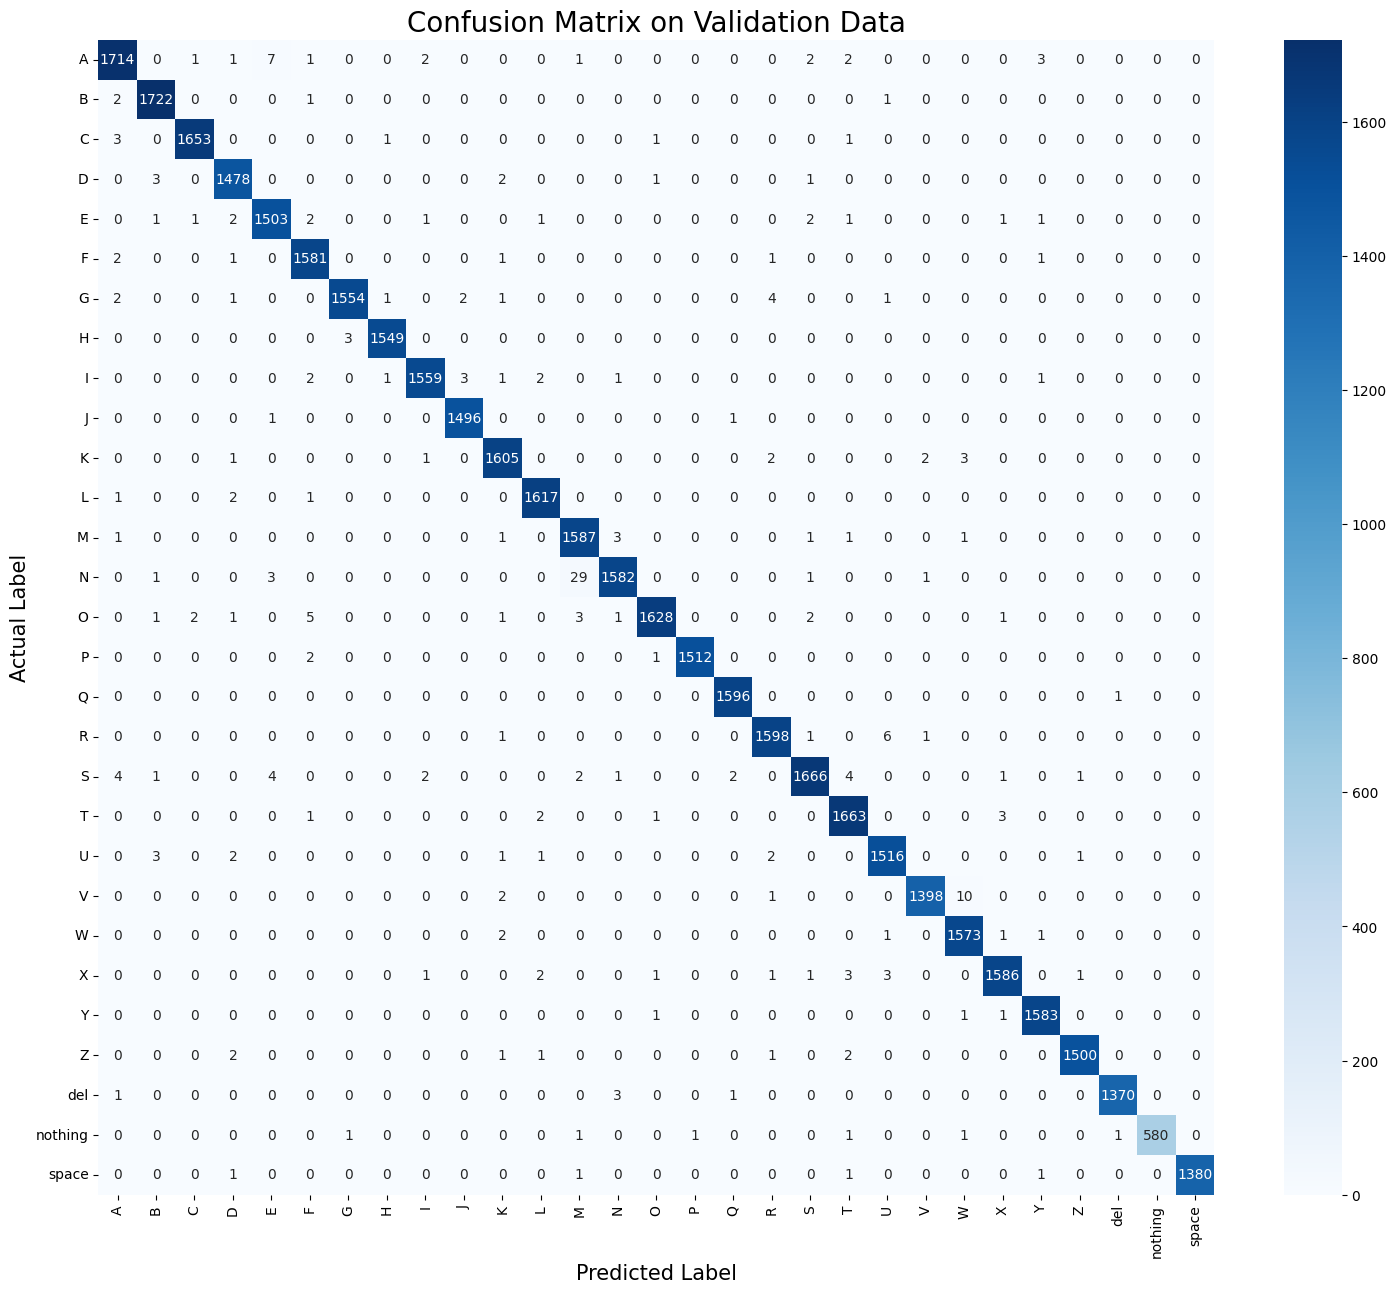

In [26]:
# --- 6. Evaluate the Model on the Validation Set ---
print("\n--- Evaluating on Validation Set ---")

y_pred = []
y_true = []
for images, labels in validation_dataset:
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

# 1. Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_names))

# 2. Confusion Matrix Heatmap
print("\n--- Generating Confusion Matrix Heatmap ---")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(18, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix on Validation Data', fontsize=20)
plt.ylabel('Actual Label', fontsize=15)
plt.xlabel('Predicted Label', fontsize=15)
plt.show()

In [30]:
# --- 7. Real-time Webcam Hand Sign Detection ---
import cv2

print("\n--- Starting Webcam for Real-time Detection ---")
print("Place your hand inside the green box.")
print("Press 'q' to quit the webcam window.")

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

# --- NEW: Define the Region of Interest (ROI) box ---
# Box dimensions (300x300 pixels)
box_size = 300
# Get frame dimensions to calculate the box position
ret, frame = cap.read()
if not ret:
    print("Error: Can't read initial frame.")
    exit()
height, width, _ = frame.shape

# Top-left corner of the box
x1 = int((width - box_size) / 2)
y1 = int((height - box_size) / 2)
# Bottom-right corner of the box
x2 = x1 + box_size
y2 = y1 + box_size


while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Can't receive frame. Exiting ...")
        break

    frame = cv2.flip(frame, 1)

    # --- NEW: Extract the ROI ---
    # Create the ROI from the original frame based on the calculated coordinates
    roi = frame[y1:y2, x1:x2]

    # --- Preprocess the ROI for the model ---
    # The model expects an RGB image
    rgb_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    
    # Resize the ROI to the model's expected input size
    resized_roi = cv2.resize(rgb_roi, IMG_SIZE)
    
    # Convert to a NumPy array and add a batch dimension
    img_array = tf.keras.utils.img_to_array(resized_roi)
    img_array = tf.expand_dims(img_array, 0)

    # --- Make a prediction on the ROI ---
    predictions = model.predict(img_array, verbose=0)
    predicted_index = np.argmax(predictions[0])
    predicted_class = class_names[predicted_index]
    confidence = 100 * np.max(predictions[0])

    # --- Display the prediction and the ROI box on the original frame ---
    display_text = f"Prediction: {predicted_class} ({confidence:.1f}%)"
    cv2.putText(frame, display_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    
    # --- NEW: Draw the ROI box on the frame ---
    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2) # Green box with thickness 2

    # Display the resulting frame
    cv2.imshow('ASL Hand Sign Detection (Press Q to Quit)', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
print("--- Webcam feed closed ---")


--- Starting Webcam for Real-time Detection ---
Place your hand inside the green box.
Press 'q' to quit the webcam window.
--- Webcam feed closed ---
